# Import Libraries

In [17]:
import pandas as pd
import os
import numpy as np
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

SEED = 123
random.seed(SEED)
np.random.seed(SEED)

# Read The Dataset

In [9]:
df = pd.read_csv('./Dataset/classification/Bank Customer Churn Prediction.csv')
print(df.shape)
df.info()

(10000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


# Initial EDA
- Missing Values
- Duplicated Rows
- Column Types
- Distribution

In [10]:
df = df.drop(['customer_id'],axis=1)
df = df.dropna().reset_index(drop=True)
df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [11]:
df.duplicated().sum()

0

In [12]:
cat_cols = []
num_cols = []

for i in df.columns:
    # print(str(df[i].dtype))
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

num_cols.remove('churn')

Categorical: ['country', 'gender']
Numeric: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn']


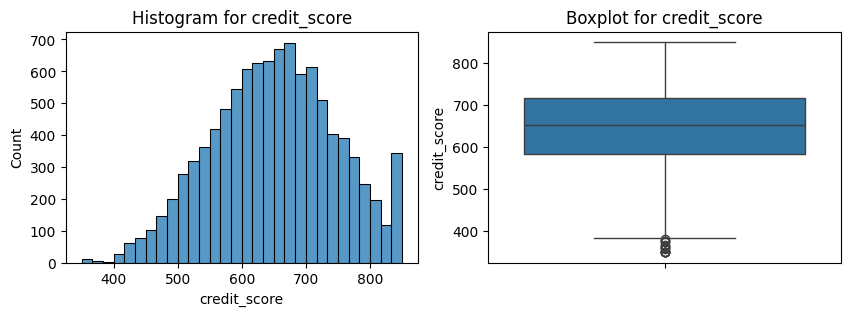

Skewness: -0.07160660820092675
Kurtosis: -0.42572568480291295


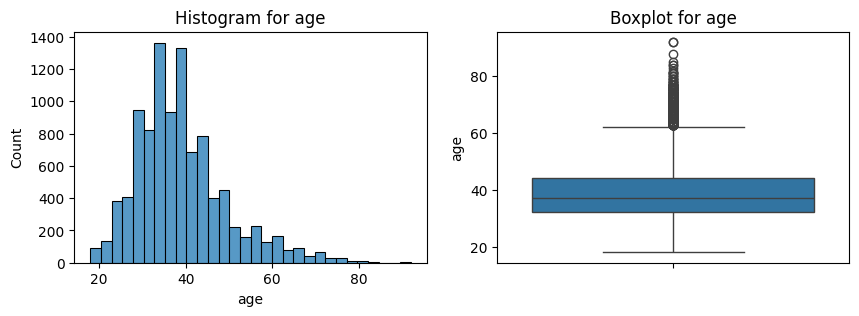

Skewness: 1.0113202630234552
Kurtosis: 1.3953470615086956


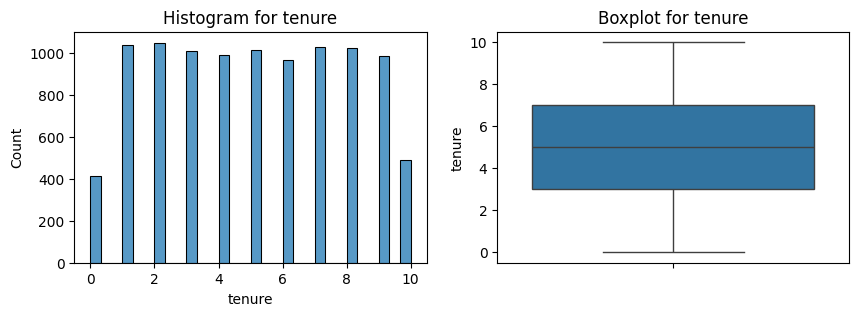

Skewness: 0.01099145797717904
Kurtosis: -1.1652252274891766


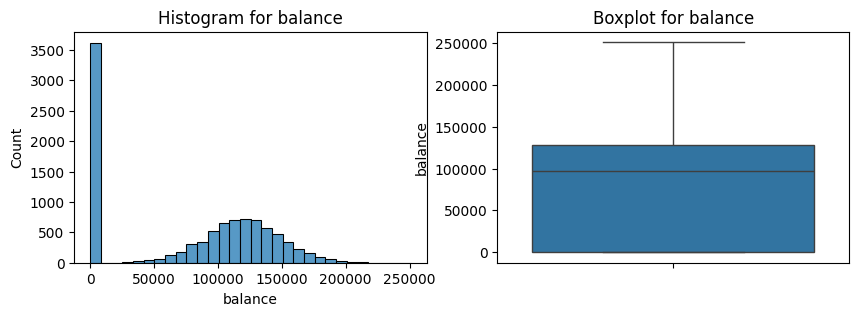

Skewness: -0.14110871094154384
Kurtosis: -1.489411767941925


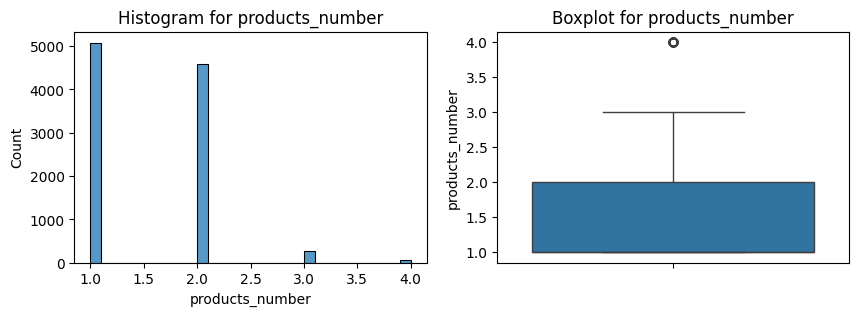

Skewness: 0.7455678882823168
Kurtosis: 0.5829807629457178


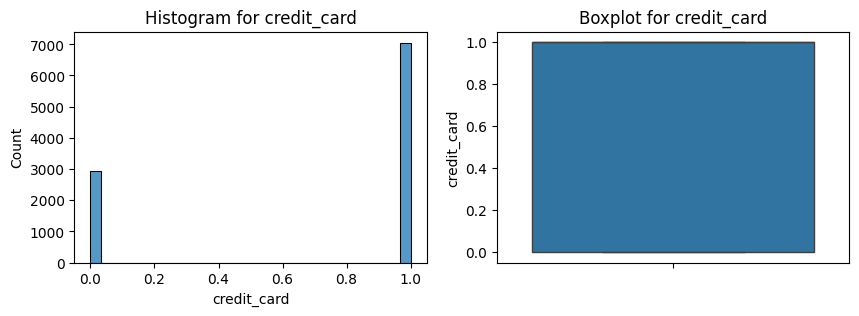

Skewness: -0.9018115952400578
Kurtosis: -1.1869732813556029


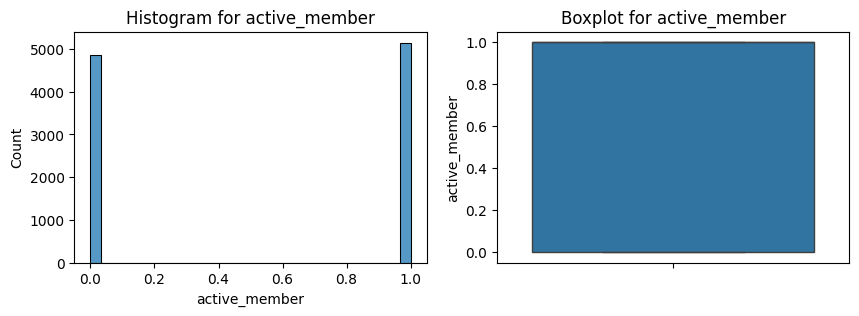

Skewness: -0.06043662833499078
Kurtosis: -1.9967468033281526


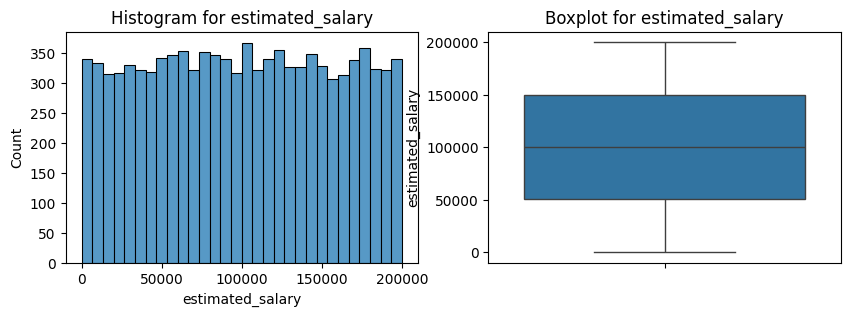

Skewness: 0.0020853576615585162
Kurtosis: -1.1815184473915485


In [13]:
def check_distribution_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30)
        plt.title('Histogram for '+col)

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title('Boxplot for '+col)

        plt.show()

        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df[num_cols], num_cols)

There are outliers in age, and some columns are actually categorical

In [ ]:
cat_cols.extend(['products_number','credit_card','active_member'])
for i in ['products_number','credit_card','active_member']:
    num_cols.remove(i)

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

Categorical: ['country', 'gender', 'products_number', 'credit_card', 'active_member']
Numeric: ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']


In [16]:
for i in cat_cols:
    print(df[i].value_counts(),'\n')

country
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64 

gender
Male      5457
Female    4543
Name: count, dtype: int64 

products_number
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64 

credit_card
1    7055
0    2945
Name: count, dtype: int64 

active_member
1    5151
0    4849
Name: count, dtype: int64 



In [18]:
df['gender'] = df['gender'].map({'Male':0,'Female':1})

In [20]:
ohe_enc = OneHotEncoder(sparse_output=False)
oh_encoded = ohe_enc.fit_transform(pd.DataFrame(df['country']))
one_hot_df = pd.DataFrame(oh_encoded, columns=ohe_enc.get_feature_names_out(['country']))

In [22]:
df = pd.concat([df.drop(columns=['country']),one_hot_df.astype('int')],axis=1)
df.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [19]:
df['churn'].value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

The data is imbalanced. We can expect the model to be a bit biased towards the majority class (0).

# Pre-processing

In [23]:
x = df.drop('churn', axis=1)
y = df['churn']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=SEED)
print(y_train.shape, y_test.shape)

(8000,) (2000,)


In [24]:
scaler = StandardScaler()
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

In [27]:
x_train.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain
9216,0.765493,0,-0.842293,1.723525,-1.220873,2,1,1,-0.792237,1,0,0
7324,-0.445505,1,0.012056,1.723525,-1.220873,3,1,0,0.570243,1,0,0
918,1.386518,0,-0.367655,-0.696731,-1.220873,2,0,0,-0.319681,0,0,1
5902,0.454981,0,0.106983,1.377774,-1.220873,2,1,0,-1.031874,1,0,0
2807,0.568835,0,-0.557510,-0.696731,1.083582,2,1,0,0.242175,1,0,0


# Training The ML Model

In [28]:
model = SVC(probability=True)
model.fit(x_train, y_train)

y_preds = model.predict(x_test)
y_preds_proba = model.predict_proba(x_test)

In [29]:
y_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

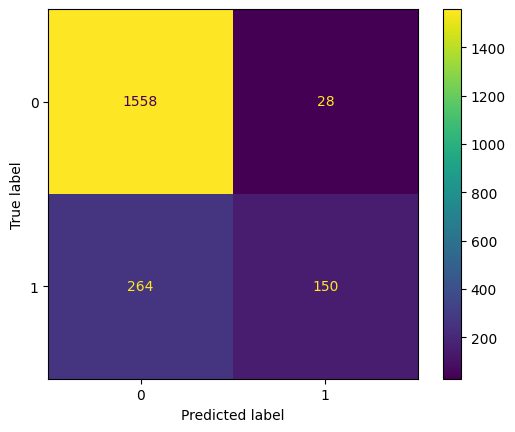

In [30]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()


In [31]:
print(classification_report(y_test,y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1586
           1       0.84      0.36      0.51       414

    accuracy                           0.85      2000
   macro avg       0.85      0.67      0.71      2000
weighted avg       0.85      0.85      0.83      2000



Well, the results are . . . . not too good. Can class weighting improve it?

# Add Class Weighting

In [33]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = class_weights
cw_dict = {0:class_weights[0],1:class_weights[1]}

model = SVC(probability=True,class_weight=cw_dict)
model.fit(x_train, y_train)

y_preds = model.predict(x_test)
y_preds_proba = model.predict_proba(x_test)

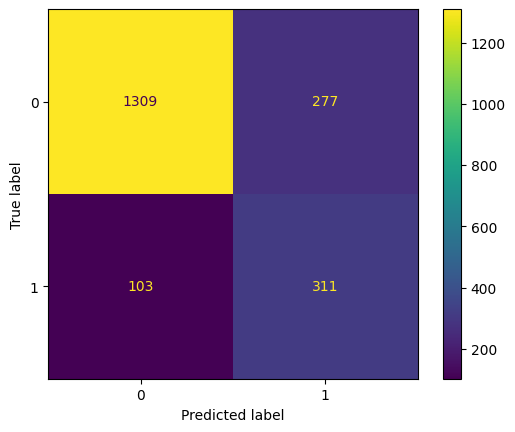

In [34]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()


In [35]:
print(classification_report(y_test,y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.93      0.83      0.87      1586
           1       0.53      0.75      0.62       414

    accuracy                           0.81      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.84      0.81      0.82      2000



Well, the model improves. Let's fine-tune it.

# Fine-tune The Model

In [37]:
parameters = {
    'C':[1,10,50],
    'kernel':['linear','rbf'],
    'probability':[True],
    'class_weight':[cw_dict],
    'random_state':[SEED]}

In [38]:
%%time
model_gs = GridSearchCV(SVC(), parameters, verbose=2)
model_gs.fit(x_train, y_train)

y_preds = model_gs.predict(x_test)
y_preds_proba = model_gs.predict_proba(x_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END C=1, class_weight={0: 0.6272541947624275, 1: 2.4645717806531113}, kernel=linear, probability=True, random_state=123; total time=   5.3s
[CV] END C=1, class_weight={0: 0.6272541947624275, 1: 2.4645717806531113}, kernel=linear, probability=True, random_state=123; total time=   5.2s
[CV] END C=1, class_weight={0: 0.6272541947624275, 1: 2.4645717806531113}, kernel=linear, probability=True, random_state=123; total time=   6.0s
[CV] END C=1, class_weight={0: 0.6272541947624275, 1: 2.4645717806531113}, kernel=linear, probability=True, random_state=123; total time=   5.4s
[CV] END C=1, class_weight={0: 0.6272541947624275, 1: 2.4645717806531113}, kernel=linear, probability=True, random_state=123; total time=   5.1s
[CV] END C=1, class_weight={0: 0.6272541947624275, 1: 2.4645717806531113}, kernel=rbf, probability=True, random_state=123; total time=   5.2s
[CV] END C=1, class_weight={0: 0.6272541947624275, 1: 2.4645717806531113}

In [42]:
model_gs.best_params_

{'C': 1,
 'class_weight': {0: 0.6272541947624275, 1: 2.4645717806531113},
 'kernel': 'rbf',
 'probability': True,
 'random_state': 123}

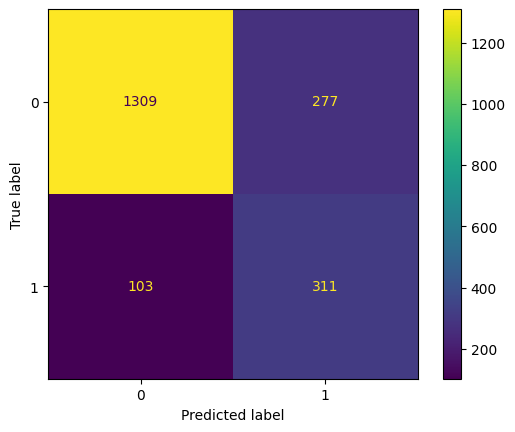

In [43]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()


In [44]:
print(classification_report(y_test,y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.93      0.83      0.87      1586
           1       0.53      0.75      0.62       414

    accuracy                           0.81      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.84      0.81      0.82      2000



As it turns out, the default settings worked the best!

# Export The Model

In [45]:
EXP_PATH = "./exp"
os.makedirs(EXP_PATH, exist_ok=True)

with open(f'{EXP_PATH}/model.pkl', 'wb') as f:
    pickle.dump(model_gs.best_estimator_, f)